# <span style="color:Purple">Project 3 :  Web APIs & NLP</span> <img src="../resources/reddit_logo.png" width="110" height="110" />
---
## <span style="color:Orange">Preprocessing - Modeling</span>      

#### Ryan McDonald

### Notebook Contents:

- [Reading the Data](#intro)
- [Overview of Count Vectorizer](#overview)
- [Modeling](#modeling)
    - [Production Model](#prod)
        - [Extended Analysis](#analysis)
    - [Model #2](#2)
    - [Model #3](#3)
    - [Model #4](#4)
    - [Model #5](#5)
    - [Model #6](#6)



**Imports**

In [10]:
# Baseline Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Models!!!S
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC

# Metrics!!!
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# GUI!!!
import tkinter as tk
from tkinter import simpledialog

<a id='intro'></a>

## 1. Read the Data

In [11]:
#None-Tokenized DataFrame
subs_notoken =pd.read_csv('../datasets/title_data')
subs_notoken

,subreddit,title
0,VanLife,Treasure at the end of the rainbow. Gonzaga Ba...
1,VanLife,Boulder Colorado :)
2,VanLife,If you like YouTube Poop you're gonna love my ...
3,VanLife,Love the boondocking near Ventura on the coast
4,VanLife,What is this silver box? It's in a 1992 SMB
...,...,...
7995,camping,Website for camping?
7996,camping,Camping near Wild Willy's Hot Spring/eastern s...
7997,camping,Camping in the boundary waters
7998,camping,Favorite camping spot in El Dorado National Fo...


In [12]:
subs_notoken['title'][3999]

'Considering the van life, should I sell my car and use my van as a daily driver?'

In [13]:
# Sentence Tokenized DataFrame
subs =pd.read_csv('../datasets/tokenized_df')
subs

,subreddit,title
0,camping,First tim camping Camping Tricks: A few of the...
1,camping,Last summer.
2,camping,We were playing war.
3,camping,I caught the moment the cards were read.
4,camping,Joshua Tree National Park back country!
...,...,...
6366,VanLife,I’m kinda new to this whole reddit thing!
6367,VanLife,But this is my 1994 VW 1.9D T4🤙🏻 Ford Econolin...
6368,VanLife,"When camping in a national park, can you reser..."
6369,VanLife,Thanks!


<a id='overview'></a>

## 2. Quick Overview of Count Vectorizing

In [14]:
# Changing subreddit labels for modeling!

my_dict = {
    'camping':0,
    'VanLife':1
}

subs['subreddit']= subs['subreddit'].map(my_dict)
subs.head()

,subreddit,title
0,0,First tim camping Camping Tricks: A few of the...
1,0,Last summer.
2,0,We were playing war.
3,0,I caught the moment the cards were read.
4,0,Joshua Tree National Park back country!


In [15]:
X = subs['title']
y = subs['subreddit']

# Subreddit is close to normalized, but will stratify on 'y' as a best practice

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

### A quick Preview of a CVEC 'densified' DataFrame before running a PipeLine
**Starting with CountVectorizer (combines several preprocessing steps in one**

In [16]:
# maintaining defualts values stopwords=None, to start.
# also defaults by stripping punctuation

cvec= CountVectorizer(min_df = 2, ngram_range=(1,1), stop_words='english' )
# a words much appear more than ONCE to be counted
cvec.fit(X_train)

CountVectorizer(min_df=2, stop_words='english')

In [17]:
# Transform the corpus (data)

X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

**'densifying' and building a DataFrame from the sparse matrix**

In [18]:
pd.DataFrame(X_train_cv.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Replacing column names with the words they represent

X_train_df = pd.DataFrame(X_train_cv.todense(), columns = cvec.get_feature_names())
X_train_df.head()

,00,000,000km,01,02,03,10,100,1000,1000w,...,zeltausstellung,zero,zion,zip,älvdalen,ペン型300mwレーザーポインター,レーザーポインター,強力,紫光レーザー光線,赤光
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**An interesting result! Considering this is a global forum, I would assume there may be several languages represented within the data. Curious to see how to runs in the model.  May need to conduct additional filtering, TBD**

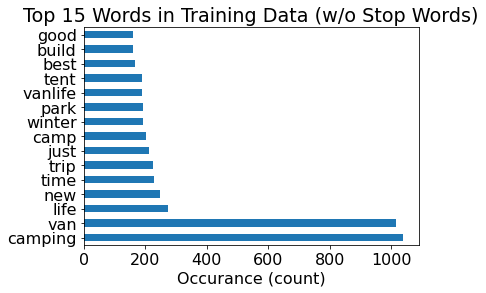

In [21]:
# lets investigate whether or not in remove 'stop words'

X_train_df = pd.DataFrame(X_train_cv.todense(),columns= cvec.get_feature_names())

X_train_df.sum().sort_values(ascending= False).head(15).plot(kind = 'barh')
plt.xlabel('Occurance (count)')  
plt.title("Top 15 Words in Training Data (w/o Stop Words)")

plt.rcParams.update({'font.size': 16})
plt.show()

#### A reminder of the Baseline score...

In [22]:
y.value_counts(normalize= True)

1    0.54701
0    0.45299
Name: subreddit, dtype: float64

<a id='modeling'></a>

## 3. Modeling

<a id='prod'></a>
## Model #1 (Production Model) - CVEC/BNB

**Production model performed 1% better on testing data with the non-sent-tokenized data!**


**Basline Model Accuracy for non-Tokenized DataFrame:**

In [23]:
subs_notoken['subreddit'].value_counts(normalize=True)

VanLife    0.5
camping    0.5
Name: subreddit, dtype: float64

In [24]:
# Will begin with a pipeline - CVEC transformer with BernoulliNB estimator
# Production model performed 1% better on testing data with the non-sent-tokenized data!

X = subs_notoken['title']
y = subs_notoken['subreddit']

# Subreddit is close to normalized, but will stratify on 'y' as a best practice

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)


pipe= Pipeline([
    ('tf', TfidfVectorizer()),
    ('bnb', BernoulliNB())])
    

In [25]:
# GridSearch through out hyperparameters!
# setting up parameter dictionary:

pipe_params= {'tf__stop_words':['english', None], # to use the 'stop_words' dict, or not!    
              'tf__ngram_range':[(1, 2), (2,2)],  # unigrams, and bigrams
              'tf__analyzer':['word'],            # defualt value to make 'grams' a 'word'
              'tf__min_df':[0, 5, 10]             # ignore words with less document frequency
}

In [26]:
# Instatiating GridSearchCV

gs= GridSearchCV(pipe,
                param_grid=pipe_params,
                cv=8,                    # 8 fold cross validation
                verbose = 1)
gs.fit(X_train, y_train)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    9.8s finished


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tf__analyzer': ['word'], 'tf__min_df': [0, 5, 10],
                         'tf__ngram_range': [(1, 2), (2, 2)],
                         'tf__stop_words': ['english', None]},
             verbose=1)

**Pickling Model For Future Needs, if neccessary**

In [27]:
with open('../pickles/prod_model.pkl', mode ='wb') as pickle_out:
    pickle.dump(pipe, pickle_out)

<a id='analysis'></a>
### Production Model Analysis 

In [28]:
gs.best_params_

{'tf__analyzer': 'word',
 'tf__min_df': 0,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': 'english'}

**The model, surprisingly decided to move forward with min_df= 0.  I was surprised we attained the results we did when including every word, regardless of term frequency.**

In [29]:
# Score on Training and Testing Data

print(f'Training Accuracy Score is: {gs.score(X_train, y_train)}')
print(f'Testing Accuracy Score is: {gs.score(X_test, y_test)}')

Training Accuracy Score is: 0.9695
Testing Accuracy Score is: 0.8755


**Our model succesfully predicted 87.6% of the classes correctly!  Excellent!**

**Pros:**  

TFIDF worked very well in this model.  Similar to CountVectorizer (used in several other model iterations, below), TFIDF does a great job developing a count matrix from the text data in our titles.  This made it very straight forward to model.  Then within the TFIDF funcitonality is the IDF transformer.  This brings a 'weight' parameter into the information. The 'inverse document frequency' takes away the 'weight' of words that may occur many many times through all of the corpus and applies more weight to words occuring less frequently.  Once the BernoulliNB classifier was deployed onto the TFIDF transformed data, BNB quickly catergorized the binary features into the appropriate class and produced a great accuracy score.

**Downsides:**  

The model is pretty overfit!  This model wouldn't necessarily work in other types of analysis, but for this problem statement, we are more interested in the testing accuracy score.  Since this model produced the highest testing accuracy, we are going into production! We could infer that this model would perform well on other subreddit data, but perhaps not on other types of classification information, say weather statistics, or traffic light patterns. 

**This is just part of the answer.  Accuracy looks great (best of our models).  Let's take a look at the misclassification rate, via the Confusion Matrix!** 

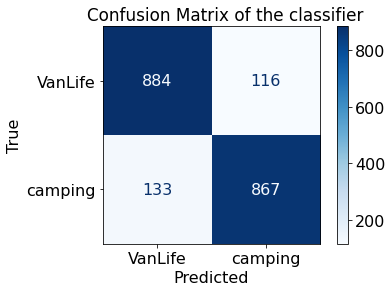

In [30]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');

plt.rcParams.update({'font.size': 14})
plt.title('     Confusion Matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
# Misclassification Rate
print(f'Misclassification Rate is: {((fp+fn)/ (tp + fp + tn + fn))}')

Misclassification Rate is: 0.1245


**The model incorrectly predicted 12.4% of the observations**

In [32]:
# Producing a dataframe with our PREDICTIONS to see which were misclassified!

preds = gs.predict(X_test)
predictions_dict = {
    # original, not cv - will be more readable
    'original text': X_test,
    # true label
    'actual': y_test,
    # predicted label
    'predictions': preds
}
# cast to df
pd.set_option("display.max_colwidth", None)
predictions_df = pd.DataFrame(predictions_dict)
predictions_df=predictions_df[predictions_df['actual'] != predictions_df['predictions']]
predictions_df.shape

(249, 3)

### Which Titles Were Misclassified?

In [33]:
predictions_df.head(10)
# Hard to tell by reading the titles why they were not classified correctly!

,original text,actual,predictions
1540,Can rock guard undercoating spray really reduce condensation?,VanLife,camping
854,Equipment Recommendations,VanLife,camping
6938,I couldnt afford a camper so I built my own put of craigslist trailer.,camping,VanLife
2343,Single parents?,VanLife,camping
3087,Winnabego Rialta,VanLife,camping
6881,I can't 👀😂😭,camping,VanLife
3741,"Exploring the eastern sierras in our wagon, Sheela 🙂",VanLife,camping
2388,Cool smoky evening in Colorado,VanLife,camping
3878,"Before and After. Test run last week, engine work this week, then we are off in the UK until Xmas :) let us know some places to see, things to do, what to know and best overnight sleep options! Wild camping is easy in Scotland, but England and Wales might be more trying?",VanLife,camping
1440,Road Trip NYC to LA,VanLife,camping


Unfortunately, no clear deciding factor could be determined by reviewing our misclassified data. However, r/camping titles were predicted incorrectly 17% more often than Camping titles. These titles ranged form foreign languages, Emoticon-filled sentences, and random, more non-descript titles.  Further analysis may reveal more insights. 


In [35]:
predictions_df['actual'].value_counts(normalize=True)

camping    0.534137
VanLife    0.465863
Name: actual, dtype: float64

**For this model, with a .50 baseline score, the posts could have gone either way!.  But, seeing a bias towards Camping posts being misclassified was interesting. However, with the word 'camping' appearing more than any other (without stopwords) it makes sense.**

### User GUI For Testing Titles!
**When the cell is ran, enter your title, and the appropriate subreddit to post in will display below the cell!**

In [36]:
pipe3 = Pipeline([
    ('tf', TfidfVectorizer(stop_words='english',ngram_range=(1, 2),analyzer= 'word',min_df=0)),
    ('bnb', BernoulliNB())])

pipe3.fit(X_train, y_train)



import tkinter as tk
from tkinter import simpledialog

ROOT = tk.Tk()

ROOT.withdraw()
# the input dialog
USER_INP = simpledialog.askstring(title="Which SubReddit",
                                  prompt="What is your title?:")


# check it out
pipe3.predict([USER_INP])



array(['VanLife'], dtype='<U7')

### Which words were most important to the model?

**Based on the inverse document frequency of the word**

**Top IDF words were ran through the predicter GIU above to develop the 'predicted class' column**

In [37]:
list =['VanLife','camping','VanLife','VanLife','VanLife','VanLife','VanLife','VanLife','VanLife','camping']
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), analyzer ='word', min_df=5)
 
tfidf.fit(X_train)

tfidf_dict = {
    'words' :tfidf.get_feature_names(),
    'idf':tfidf.idf_  
}
tfidif_dict = pd.DataFrame(tfidf_dict)
top_10_idf=tfidif_dict.sort_values(by='idf', ascending = False).head(10)
top_10_idf=top_10_idf.reset_index(drop= True)
top_10_idf['predicted class']= list
top_10_idf

,words,idf,predicted class
0,die,7.907922,VanLife
1,spring camping,7.907922,camping
2,saving,7.907922,VanLife
3,scary,7.907922,VanLife
4,searching,7.907922,VanLife
5,does experience,7.907922,VanLife
6,secure,7.907922,VanLife
7,services,7.907922,VanLife
8,sf,7.907922,VanLife
9,shed,7.907922,camping


**80% of the top ten most 'important' words/phrases as determined by IDF are predicted to be associated with VanLife.  With these statistics, I would have expected the misclassified words to weigh heavier on the VanLife class.**

---

<a id='2'></a>
## Additional Models have limited interpretations, however, some interesting finding are discussed below applicable models

## Model #2 - CVEC/RFC

#### <span style="color:Red">**Warning!! This Model Takes over an HOUR to run!**</span>     

**Model is pickled below incase additional metrics are desired!**

In [103]:
# # Will begin with a pipeline - CVEC transformer with Random Forest Classifier

# pipe= Pipeline([
#     ('cvec', CountVectorizer()),
#     ('rf', RandomForestClassifier()) # internally bagging! Bootstrap = True
# ])


In [104]:
# # GridSearch through out hyperparameters!
# # setting up parameter dictionary:

# pipe_params= {'cvec__stop_words':['english', None],       # with and without stopwords
#     'cvec__max_features':[None, 2000, 3000, 4000, 5000],  # number of highest frequency features to use
#     'cvec__min_df':[2, 3],                                # ignore words at these low frequencies
#     'cvec__ngram_range':[(1, 1), (1, 2)],                 # unigrams and bigrams
#     'rf__n_estimators': [100, 200, 250],                  # # of trees in forest
#     'rf__max_depth':[None, 1, 2, 3, 4, 5, 10],            # max depth of 'tree'
#     'rf__criterion':['gini', 'entropy']                   # quality of split
              
# }

In [106]:
# # Instatiating GridSearchCV

# gs= GridSearchCV(pipe,
#                 param_grid=pipe_params,
#                 cv=5,                    # 5 fold cross validation
#                 verbose = 1)
# gs.fit(X_train, y_train)

In [107]:
# # the model# 2 above took 81 minutes to run!  Pickling it in case I need to come back to it later!

# with open('../pickles/model_2.pkl', mode ='wb') as pickle_out:
#     pickle.dump(pipe, pickle_out)

**Below is the pickle open code if needed!**

In [108]:
# with open('../pickles/model_2.pkl', mode= 'rb') as pickle_in:
#     pipe = pickle.load(pickle_in)    

In [109]:
# # Best paramaters from our GridSearch!
# gs.best_params_

In [110]:
# print(f'Training Accuracy Score is: {gs.score(X_train, y_train)}')
# print(f'Testing Accuracy Score is: {gs.score(X_test, y_test)}')

**Training Accuracy Score is: 0.994**
**Testing Accuracy Score is: 0.829**

In [111]:
# preds = gs.predict(X_test)
# tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
# plot_confusion_matrix(gs, X_test, y_test, cmap='Greens');

In [112]:
# # Misclassification Rate
# print(f'Misclassification Rate is: {((fp+fn)/ (tp + fp + tn + fn))}')

**The model incorrectly predicted 17.1% of the observations**

**Model appears to be very overfit.  Excellent accuracy on training data. Testing data is far off though.  Need to bring in more bias and/or limit features for next model.**

---

<a id='3'></a>
## Model #3 - TFID/LogReg

In [93]:
# WIll be Piplining TfidfVectorizer with Logistic Regression CV estimator
# But first some EDA

X = subs['title']
y = subs['subreddit']

# Subreddit is close to normalized, but will stratify on 'y' as a best practice

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

In [94]:
# which words are most important to the model?
tfidf = TfidfVectorizer(min_df=2)   # word much appear in two different docs to count
tfidf.fit(X_train)

tfidf_dict = {
    'words' :tfidf.get_feature_names(),
    'idf':tfidf.idf_
}
tfidif_dict = pd.DataFrame(tfidf_dict)
tfidif_dict.sort_values(by='idf', ascending = False).head(10)


,words,idf
3781,赤光,8.373374
2413,pants,8.373374
1007,dm,8.373374
1005,diving,8.373374
1003,distancing,8.373374
2406,palo,8.373374
1000,disperse,8.373374
2411,paneling,8.373374
997,disney,8.373374
996,dish,8.373374


**Tfidf deams 赤光 (akimitsu- manderin for 'bright', 'light' the most important word in the corpus!.  'Paola' is also a latin word by origin.  Interesting how the model pulled these words out**

In [95]:
X_train_df[['赤光', 'subreddit']].groupby('subreddit').sum()

# this word appears only twice in 'camping' subreddit!

,赤光
subreddit,
0,2
1,0


In [98]:
# Pipline for tfidf and logistic regression CV

pipe2 = Pipeline([
    ('tf', TfidfVectorizer(stop_words='english',ngram_range=(1, 2), analyzer ='word', min_df=5)),
    ('lr', LogisticRegressionCV(solver = 'liblinear', penalty='l2', cv=5, random_state = 42))
])

pipe2.fit(X_train, y_train)

print(f'Training Accuracy Score is: {pipe2.score(X_train, y_train)}')
print(f'Testing Accuracy Score is: {pipe2.score(X_test, y_test)}')

Training Accuracy Score is: 0.9223524487233152
Testing Accuracy Score is: 0.8411801632140615


**Model appears to be overfit.  Excellent accuracy on training data. Testing data is far off though.  Need to bring in more bias and/or limit features for next model.**

**Overall, testing accuracy is close to our production model!**

In [102]:
# Running a Prediction
pipe2.predict(['Look at my van!'])

array([1], dtype=int64)

---

<a id='4'></a>
## Model #4- CVEC/DTC

In [38]:
# Will be Piplining CountVectorizor transformer with DecisionTreeClassifier estimator

X = subs['title']
y = subs['subreddit']

# Subreddit is close to normalized, but will stratify on 'y' as a best practice

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

In [63]:
pipe3 = Pipeline([
    ('cv', CountVectorizer(min_df=2, stop_words='english')),
    ('dtc', DecisionTreeClassifier(max_depth =40, random_state = 42, min_samples_leaf= 3))
])
pipe3.fit(X_train, y_train)

print(f'Training Accuracy Score is: {pipe3.score(X_train, y_train)}')
print(f'Testing Accuracy Score is: {pipe3.score(X_test, y_test)}')

Training Accuracy Score is: 0.8110627719080175
Testing Accuracy Score is: 0.7956521739130434


**Model 4 does not perform as well as the others. Will continue on to work with better performers.**

<a id='5'></a>
## Model #5 - CVEC/ ADA Boost

In [92]:
# Will begin with a pipeline - CVEC transformer with AdaBoost Classifier
# AdaBoost performed better than XGBoost!
# Utilizing tokenized dataset yielded better results!
X = subs['title']
y = subs['subreddit']

# Subreddit is close to normalized, but will stratify on 'y' as a best practice

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

pipe4= Pipeline([
    ('cvec', CountVectorizer()),
    ('abc', AdaBoostClassifier(random_state=42))
])


In [74]:
# GridSearch through our hyperparameters!
# setting up parameter dictionary:

pipe4_params= {'cvec__stop_words':['english', None],    # with and without stopwords
    'cvec__max_features':[None, 2000, 3000],           # number of highest frequency features to use
    'cvec__min_df':[2, 3],                             # ignore words at these low frequencies
    'cvec__ngram_range':[(1, 1), (1, 2)],              # unigrams and bigrams                      
}

In [75]:
# Instatiating GridSearchCV

gs2= GridSearchCV(pipe4,
                param_grid=pipe4_params,
                cv=5,                    # 5 fold cross validation
                verbose = 1)
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('abc',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'cvec__max_features': [None, 2000, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]},
             verbose=1)

In [76]:
gs2.best_params_

{'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [77]:
print(f'Training Accuracy Score is: {gs2.score(X_train, y_train)}')
print(f'Testing Accuracy Score is: {gs2.score(X_test, y_test)}')

Training Accuracy Score is: 0.7992884051904563
Testing Accuracy Score is: 0.7928436911487758


**Model #5 did NOT perform very well.  Will move on to other models**

<a id='6'></a>
## Model #6 - CVEC/SVC

In [84]:
# Will begin with a pipeline - CVEC transformer with LinearSVC estimator
# Utilizing non-tokenized dataset yielded better results!
X = subs_notoken['title']
y = subs_notoken['subreddit']

# Subreddit is close to normalized, but will stratify on 'y' as a best practice

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

pipe5= Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', LinearSVC(random_state= 42, max_iter=5000, C=0.07 ))
])

In [85]:
# GridSearch through out hyperparameters!
# setting up parameter dictionary:

pipe_params= {'cvec__stop_words':['english', None],
    'cvec__max_features':[None, 2000, 3000, 4000],
    'cvec__min_df':[2, 3],
    'cvec__ngram_range':[(1, 1), (1, 2)],
    }

In [86]:
# Instatiating GridSearchCV

gs= GridSearchCV(pipe5,
                param_grid=pipe_params,
                cv=5)

In [87]:
# Fitting GS to training data
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc',
                                        LinearSVC(C=0.07, max_iter=5000,
                                                  random_state=42))]),
             param_grid={'cvec__max_features': [None, 2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]})

In [88]:
# Best paramaters from our GridSearch!
gs.best_params_

{'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [89]:
# Score on Training and Testing Data

print(f'Training Accuracy Score is: {gs.score(X_train, y_train)}')
print(f'Testing Accuracy Score is: {gs.score(X_test, y_test)}')

Training Accuracy Score is: 0.9453333333333334
Testing Accuracy Score is: 0.8565


**This is just part of the answer.  Accuracy looks decent at 85.7%, And, VERY CLOSE to our production model. However, our Production model outperforms by a bit, AND runs much faster.**

**Let's still take a look at the misclassification rate, via the Confusion Matrix!** 

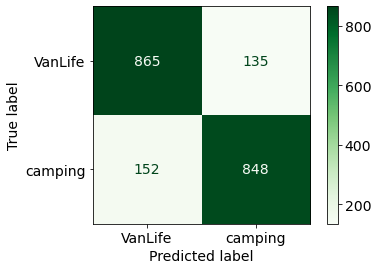

In [90]:
preds = gs.predict(X_test)
tn, fp, fn, tp =confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens');

In [91]:
# Misclassification Rate
print(f'Misclassification Rate is: {((fp+fn)/ (tp + fp + tn + fn))}')

Misclassification Rate is: 0.1435


**The model incorrectly predicted 14.4% of the observations**

---